# Notebook for visualizing MVP phase 2 coherence check results

Coherence check includes results generated by FastQC, Samtools Flagstat, and RTG Vcfstats.

In [4]:
from io import StringIO

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import google.datalab.bigquery as bq

# MVP Phase 2 FastQC Results (n=1902)

In [5]:
mvp_fastqc_table="gbsc-gcp-project-mvp.testing.Jina_testing_fastqc"

## Per base quality

In [6]:
per_base_qual = bq.Query('SELECT index, ' +
                         'ROUND(CAST(value AS FLOAT64), 1) AS value_tenth, ' +
                         'COUNT(*) AS observations ' +
                         'FROM `' + mvp_fastqc_table + '` ' +
                         'WHERE dimension = "per_base_qual" ' +
                         'GROUP BY index, value_tenth').execute().result().to_dataframe()
per_base_qual.head()

,index,value_tenth,observations
0,90-91,29.0,1
1,64-65,29.0,1
2,48-49,29.0,1
3,50-51,29.0,1
4,46-47,29.0,1


In [7]:
start_end = pd.DataFrame(per_base_qual['index'].str.split('-',1).tolist(), columns=['start', 'end'])
per_base_qual = per_base_qual.join(start_end)

per_base_qual[['value_tenth']] = per_base_qual[['value_tenth']].apply(pd.to_numeric)
per_base_qual[['start']] = per_base_qual[['start']].apply(pd.to_numeric)
per_base_qual[['observations']] = per_base_qual[['observations']].apply(pd.to_numeric)

per_base_qual.head()

,index,value_tenth,observations,start,end
0,90-91,29.0,1,90,91
1,64-65,29.0,1,64,65
2,48-49,29.0,1,48,49
3,50-51,29.0,1,50,51
4,46-47,29.0,1,46,47


In [8]:
per_base_qual[['log_observations']] = np.log(per_base_qual[['observations']])
per_base_qual.head()

,index,value_tenth,observations,start,end,log_observations
0,90-91,29.0,1,90,91,0.0
1,64-65,29.0,1,64,65,0.0
2,48-49,29.0,1,48,49,0.0
3,50-51,29.0,1,50,51,0.0
4,46-47,29.0,1,46,47,0.0


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


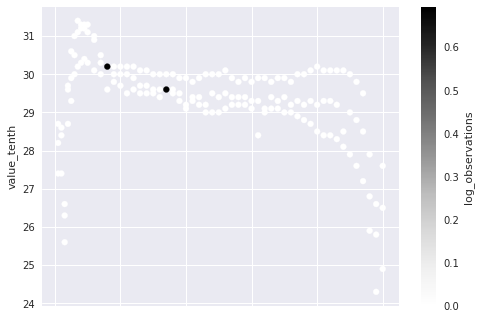

In [9]:
plot = per_base_qual.plot(kind='scatter', x='start', y='value_tenth', c='log_observations', s=35)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


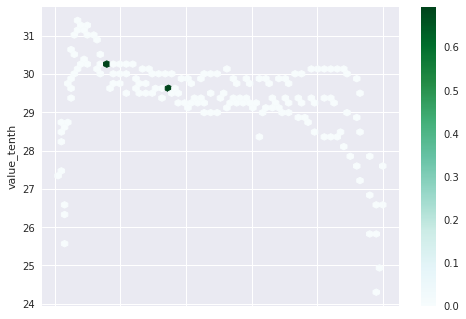

In [10]:
per_base_qual.plot.hexbin(x='start', y='value_tenth', C='log_observations', reduce_C_function=np.max, gridsize=50)
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


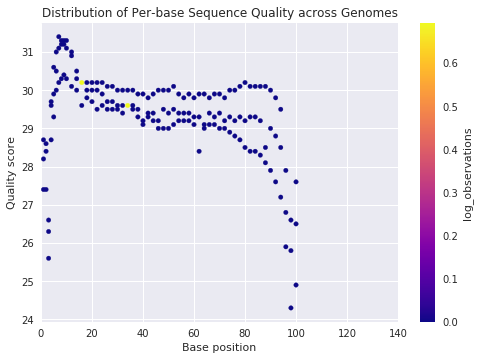

In [11]:
fig, ax = plt.subplots()
scat = per_base_qual.plot(kind='scatter', x='start', y='value_tenth', c='log_observations', cmap='plasma', ax=ax)
ax.set_xlim(0,140)
ax.set_title("Distribution of Per-base Sequence Quality across Genomes")
ax.set_xlabel("Base position")
ax.set_ylabel("Quality score")
plt.show()

## GC Content

In [12]:
dimension = "gc_content"
gc_content = bq.Query('SELECT sample, ' +
                      'dimension, ' +
                      'CAST(value AS INT64) as value ' +
                      'FROM `' + mvp_fastqc_table + '` ' +
                      'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
gc_content.head()

,sample,dimension,value
0,40013463,gc_content,40
1,40050177,gc_content,40
2,40101045,gc_content,40


In [13]:
gc_content_counts = gc_content.groupby('value')['sample'].nunique()
print (gc_content_counts)

value
40    3
Name: sample, dtype: int64


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


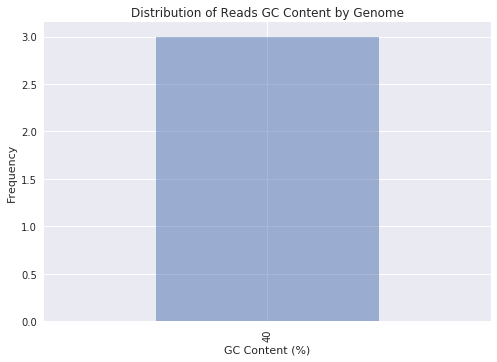

In [14]:
fig, ax = plt.subplots()
bar = gc_content_counts.plot.bar(alpha=0.5)
ax.set_title("Distribution of Reads GC Content by Genome")
ax.set_xlabel("GC Content (%)")
ax.set_ylabel("Frequency")
plt.show()

## Average sequence quality

In [15]:
dimension = "seq_quality"
avg_seq_qual = bq.Query('SELECT sample, ' +
                        'SUM(CAST(index as INT64) * CAST(value AS FLOAT64))/SUM(CAST(value AS FLOAT64)) ' +
                        'FROM `' + mvp_fastqc_table + '` ' +
                        'WHERE dimension = "' + dimension + '" ' +
                        'GROUP BY sample').execute().result().to_dataframe()
avg_seq_qual.head()

,sample,f0_
0,40013463,28.714361
1,40050177,29.421071
2,40101045,28.560744


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


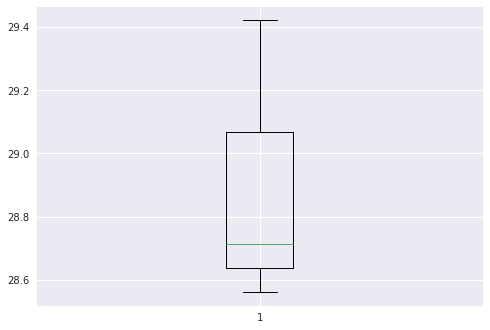

In [16]:
plt.figure()
plt.boxplot(avg_seq_qual['f0_'], 0, 'gD')
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


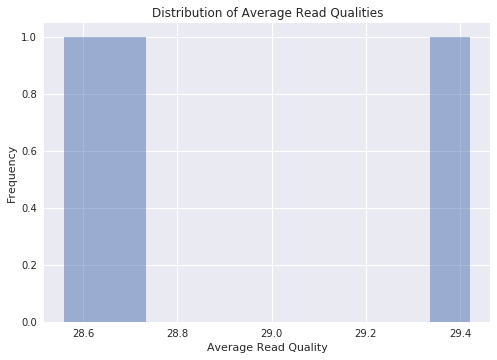

In [17]:
fig, ax = plt.subplots()
avg_seq_qual.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Average Read Qualities")
ax.set_xlabel("Average Read Quality")
ax.set_ylabel("Frequency")
plt.show()

## Sequence length

In [18]:
dimension = "seq_len"
seq_len = bq.Query('SELECT sample, dimension, ' +
                   'CAST(value AS INT64) as value ' + 
                   'FROM `' + mvp_fastqc_table + '` ' + 
                   'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
seq_len.head()

,sample,dimension,value
0,40013463,seq_len,100
1,40050177,seq_len,100
2,40101045,seq_len,100


In [20]:
seq_len_counts = seq_len.groupby('value')['sample'].nunique()
print (seq_len_counts)

value
100    3
Name: sample, dtype: int64


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


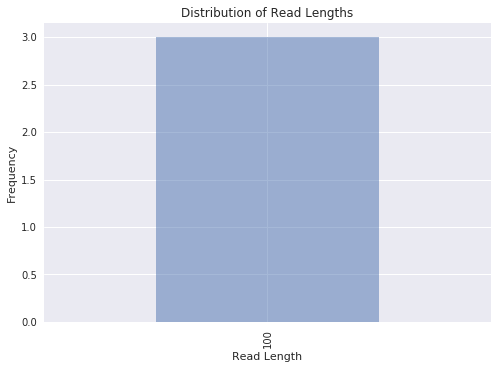

In [21]:
fig, ax = plt.subplots()
bar = seq_len_counts.plot.bar(alpha=0.5)
ax.set_title("Distribution of Read Lengths")
ax.set_xlabel("Read Length")
ax.set_ylabel("Frequency")
plt.show()

# MVP Phase 2 VCFStats Results (n=1902)

In [29]:
mvp_vcfstats_table = "gbsc-gcp-project-mvp.testing.Jina_testing_vcfstats"

## SNPs per genome

In [30]:
snps = bq.Query('SELECT sample, dimension, ' +
                'CAST(value AS INT64) as value ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension = "snps" ').execute().result().to_dataframe()
snps.head()

,sample,dimension,value
0,400744881,snps,3866075
1,402940933,snps,3863866


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


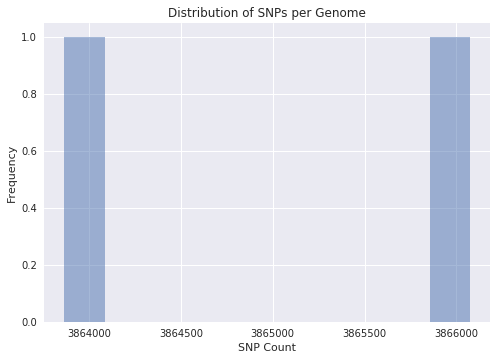

In [31]:
fig, ax = plt.subplots()
hist = snps.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of SNPs per Genome")
ax.set_xlabel("SNP Count")
ax.set_ylabel("Frequency")
plt.show()

## Check number of variants in each category
I am not sure whether RTG Tools vcfstats considers failed variants, and their documentation of vcfstats is very poor. Eye-check of ~10 vcfstats files does not show any variants marked as "Failed Filters".

I'm going to run a query to see if any were marked as failing.

In [32]:
dimension_sums = bq.Query('SELECT dimension, SUM(CAST(value AS INT64)) AS sum ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension IN ("failed_filters", "passed_filters") ' +
                'GROUP BY dimension').execute().result().to_dataframe()
dimension_sums.head()

,dimension,sum
0,failed_filters,0
1,passed_filters,711603846


## Indels per genome

In [33]:
dimension = "indels"
indels = bq.Query('SELECT sample, dimension, ' +
                  'CAST(value AS INT64) as value ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
indels.head()

,sample,dimension,value
0,402940933,indels,14126
1,400744881,indels,10000


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


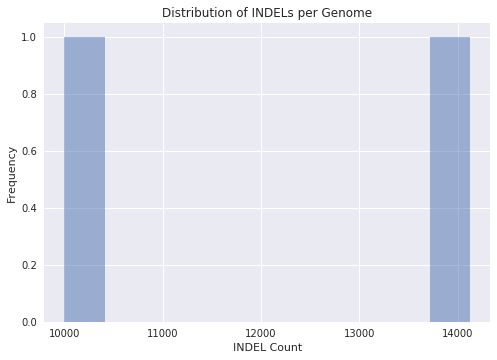

In [34]:
fig, ax = plt.subplots()
hist = indels.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of INDELs per Genome")
ax.set_xlabel("INDEL Count")
ax.set_ylabel("Frequency")
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


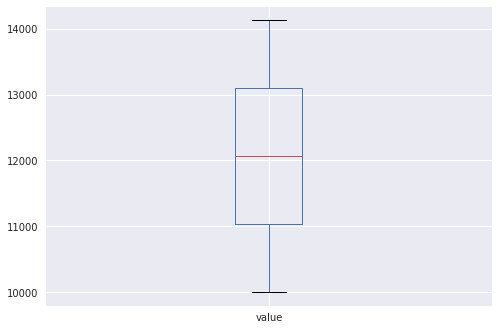

In [35]:
box = indels.plot.box()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


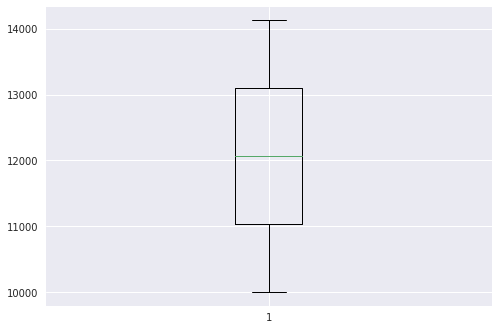

In [36]:
plt.figure()
plt.boxplot(indels['value'], 0, 'gD')
plt.show()

## Cumulative insertions, deletions, and indels
RTG Tools vcfstats outputs data on three categories of indels: insertions, deletions, and indels. From this google group post (https://groups.google.com/a/realtimegenomics.com/forum/#!searchin/rtg-users/vcfstats/rtg-users/-eFsSbWF6ks/1HrnevHTAgAJ):

>For the insertions/deletions/indels the table is based on the delta in length rather than total length (which really matters for the indels):

>Insertions (pure addition of bases)
>A -> AT (length 1 insertion)
>ATT -> ATTTT (length 2 insertion) 

>Deletions (pure deletion of bases)
>AT -> A (length 1 deletion)
>ATTTT -> ATT (length 2 deletion)

>Indels (length changing but not pure)
>ATT -> CTTT (length 1 indel)
>CTTT -> ATT (length 1 indel)"

In [37]:
indels = bq.Query('SELECT sample, SUM(DISTINCT CAST(value AS INT64)) AS cum_indels ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE dimension = "insertions" ' +
                  'OR dimension = "deletions" ' +
                  'OR dimension = "indels" ' +
                  'GROUP BY sample').execute().result().to_dataframe()
indels.head()

,sample,cum_indels
0,402940933,831019
1,400744881,755967


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


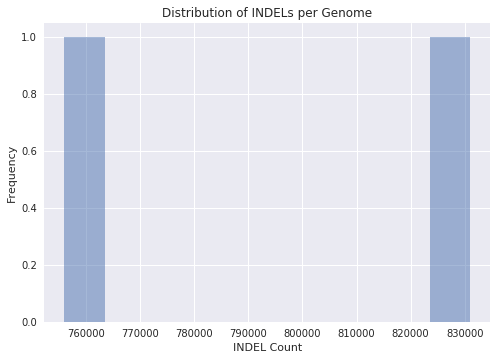

In [38]:
fig, ax = plt.subplots()
hist = indels.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of INDELs per Genome")
ax.set_xlabel("INDEL Count")
ax.set_ylabel("Frequency")
plt.show()

## Frequency of Ti/Tv ratios

In [39]:
dimension = "ti_tv_ratio"
ti_tv = bq.Query('SELECT sample, dimension, ' + 
                 'CAST(value AS FLOAT64) as value ' + 
                 'FROM `' + mvp_vcfstats_table + '` ' + 
                 'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
ti_tv.head()

,sample,dimension,value
0,400744881,ti_tv_ratio,2.02
1,402940933,ti_tv_ratio,2.01


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


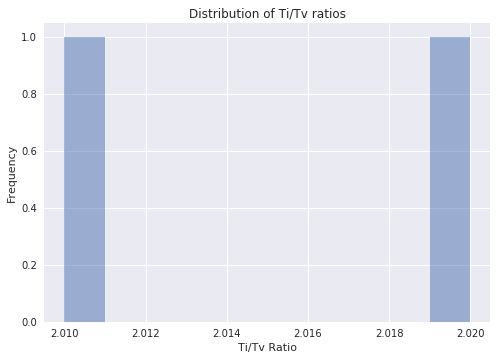

In [40]:
fig, ax = plt.subplots()
hist = ti_tv.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Ti/Tv ratios")
ax.set_xlabel("Ti/Tv Ratio")
ax.set_ylabel("Frequency")
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


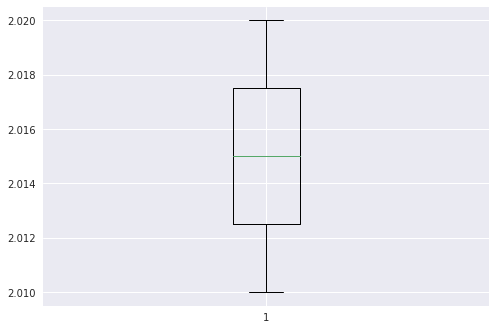

In [41]:
plt.figure()
plt.boxplot(ti_tv['value'], 0, 'gD')
plt.show()

## Frequency of SNP het/hom ratios

In [42]:
snp_het_hom_ratio = bq.Query('SELECT sample, dimension, ' + 
                             'CAST(value AS FLOAT64) as value ' + 
                             'FROM `' + mvp_vcfstats_table + '` ' + 
                             'WHERE dimension = "snp_het_hom_ratio"').execute().result().to_dataframe()
snp_het_hom_ratio.head()

,sample,dimension,value
0,400744881,snp_het_hom_ratio,1.6
1,402940933,snp_het_hom_ratio,1.6


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


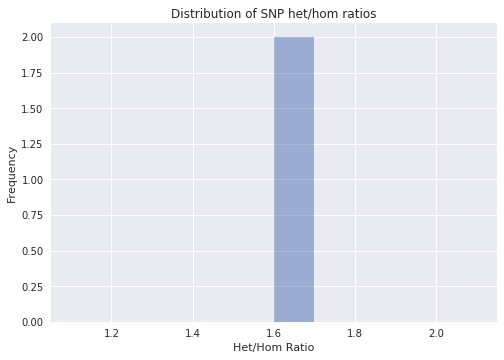

In [43]:
fig, ax = plt.subplots()
hist = snp_het_hom_ratio.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of SNP het/hom ratios")
ax.set_xlabel("Het/Hom Ratio")
ax.set_ylabel("Frequency")
plt.show()

# MVP Phase 2 Samtools Flagstat Results (n=1902)

In [44]:
mvp_flagstat_table = "gbsc-gcp-project-mvp.testing.Jina_testing_flagstat"

## Percent of reads mapped to reference

In [45]:
dimension = "mapped_reads_perc"
mapped_reads_perc = bq.Query('SELECT sample, dimension, ' + 
                             'CAST(value AS FLOAT64) as value ' + 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
mapped_reads_perc.head()

,sample,dimension,value
0,40013463,mapped_reads_perc,96.63
1,40050177,mapped_reads_perc,97.06
2,40101045,mapped_reads_perc,97.54


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


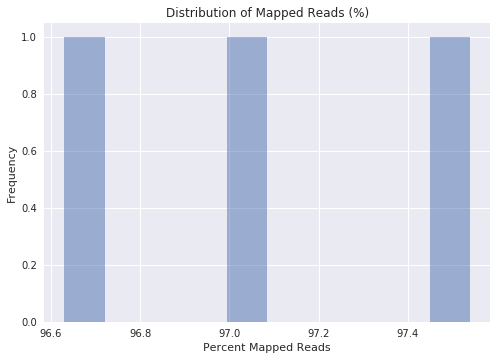

In [46]:
fig, ax = plt.subplots()
hist = mapped_reads_perc.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Mapped Reads (%)")
ax.set_xlabel("Percent Mapped Reads")
ax.set_ylabel("Frequency")
plt.show()

## Count of reads mapped to reference

In [47]:
dimension = "mapped_reads_count"
mapped_reads_count = bq.Query('SELECT sample, dimension, ' + 
                              'CAST(value AS FLOAT64) as value ' + 
                              'FROM `' + mvp_flagstat_table + '` ' + 
                              'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
mapped_reads_count.head()

,sample,dimension,value
0,40013463,mapped_reads_count,1.377723e+09
1,40050177,mapped_reads_count,1.019801e+09
2,40101045,mapped_reads_count,1.616561e+09


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


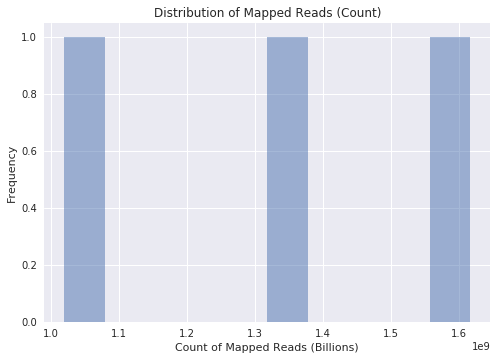

In [48]:
fig, ax = plt.subplots()
hist = mapped_reads_count.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Mapped Reads (Count)")
ax.set_xlabel("Count of Mapped Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

## Percent of reads properly paired

In [49]:
dimension = "properly_paired_perc"
properly_paired_perc = bq.Query('SELECT sample, dimension, ' + 
                                'CAST(value AS FLOAT64) as value ' + 
                                'FROM `' + mvp_flagstat_table + '` ' + 
                                'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
properly_paired_perc.head()

,sample,dimension,value
0,40013463,properly_paired_perc,94.80
1,40050177,properly_paired_perc,95.76
2,40101045,properly_paired_perc,96.41


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


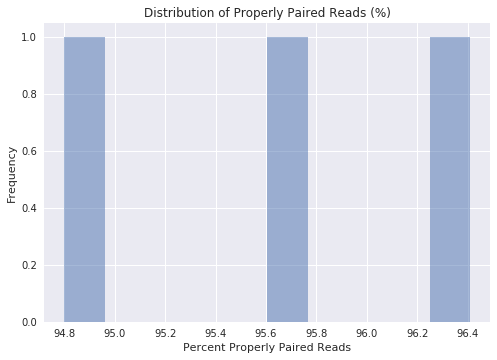

In [50]:
fig, ax = plt.subplots()
hist = properly_paired_perc.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (%)")
ax.set_xlabel("Percent Properly Paired Reads")
ax.set_ylabel("Frequency")
plt.show()

## Count of reads properly paired

In [51]:
dimension = "properly_paired_count"
properly_paired_count = bq.Query('SELECT sample, dimension, ' + 
                                 'CAST(value AS FLOAT64) as value ' + 
                                 'FROM `' + mvp_flagstat_table + '` ' + 
                                 'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
properly_paired_count.head()

,sample,dimension,value
0,40013463,properly_paired_count,1.351668e+09
1,40050177,properly_paired_count,1.006153e+09
2,40101045,properly_paired_count,1.597928e+09


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


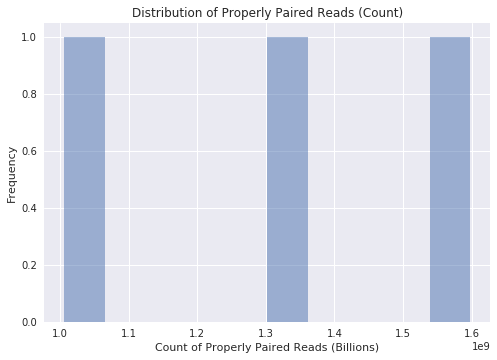

In [52]:
fig, ax = plt.subplots()
hist = properly_paired_count.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (Count)")
ax.set_xlabel("Count of Properly Paired Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()